In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16

plt.rcParams['font.size'] = 14

In [2]:
batch_size = 32
img_size = 224
directory = '/kaggle/input/animals10/raw-img'

datagen = ImageDataGenerator(rescale = 1/255.,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            validation_split = 0.15)

train_generator = datagen.flow_from_directory(directory,
                                             target_size = (img_size, img_size),
                                             batch_size = batch_size,
                                             shuffle=True,
                                             subset='training',
                                             class_mode = 'categorical')

validation_generator = datagen.flow_from_directory(directory,
                                             target_size = (img_size, img_size),
                                             batch_size = batch_size,
                                             shuffle=False,
                                             subset='validation',
                                             class_mode = 'categorical')

Found 22257 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.


In [4]:
#train_generator.__dict__
#train_generator.class_indices
[key for key in train_generator.class_indices]

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

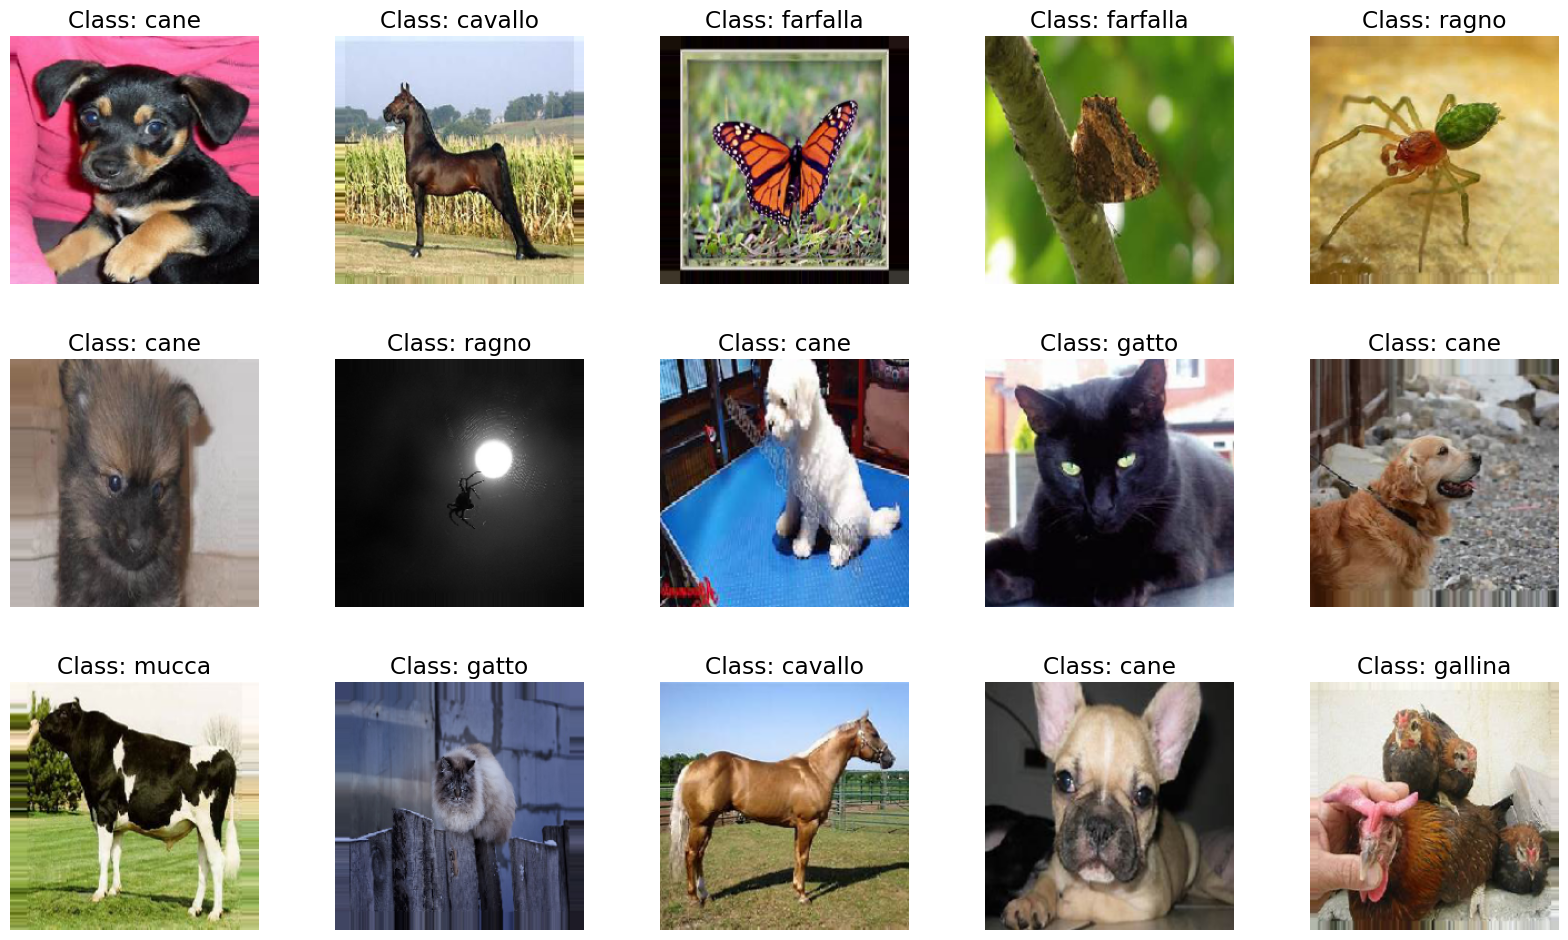

In [5]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

 

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

In VGG16, 16 is convolutional layers+FC Layers

In [8]:
img_size = 224
base_model = VGG16(include_top = False,   # include_top is to include the classifier layer; whether to include the 3 fully-connected layers at the top of the network
                  weights = 'imagenet',
                  input_shape = (img_size, img_size, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Freezing the bottom layers

In [10]:
# As per the table in sir's slides, (medium, similar)
base_model.layers

In [11]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [12]:
# base_model.layers
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

When we set a lr and convergence is slow, increase lr

reduce lr when the convergence is a plateau

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [14]:
model_name = 'model.h5'
checkpoint = ModelCheckpoint(model_name,
                            monitor = 'val_loss',
                            mode = 'min',
                            save_best_only = True,
                            verbose = 1)

earlystopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights = True)

In [15]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation = 'relu')(x)
outputs = Dense(10, activation = 'softmax')(x)
model = Model(inputs = base_model.inputs, outputs = outputs)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [16]:
history = model.fit(train_generator,
                   epochs = 3,
                   validation_data = validation_generator,
                   callbacks = [checkpoint, earlystopping])

Epoch 1/3
696/696 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.7706
Epoch 1: val_loss improved from inf to 0.41975, saving model to model.h5
696/696 [==============================] - 551s 776ms/step - loss: 0.6925 - accuracy: 0.7706 - val_loss: 0.4197 - val_accuracy: 0.8580
Epoch 2/3
696/696 [==============================] - ETA: 0s - loss: 0.3394 - accuracy: 0.8875
Epoch 2: val_loss improved from 0.41975 to 0.29590, saving model to model.h5
696/696 [==============================] - 347s 499ms/step - loss: 0.3394 - accuracy: 0.8875 - val_loss: 0.2959 - val_accuracy: 0.9031
Epoch 3/3
696/696 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.9181
Epoch 3: val_loss improved from 0.29590 to 0.26494, saving model to model.h5
696/696 [==============================] - 342s 492ms/step - loss: 0.2508 - accuracy: 0.9181 - val_loss: 0.2649 - val_accuracy: 0.9123


# 

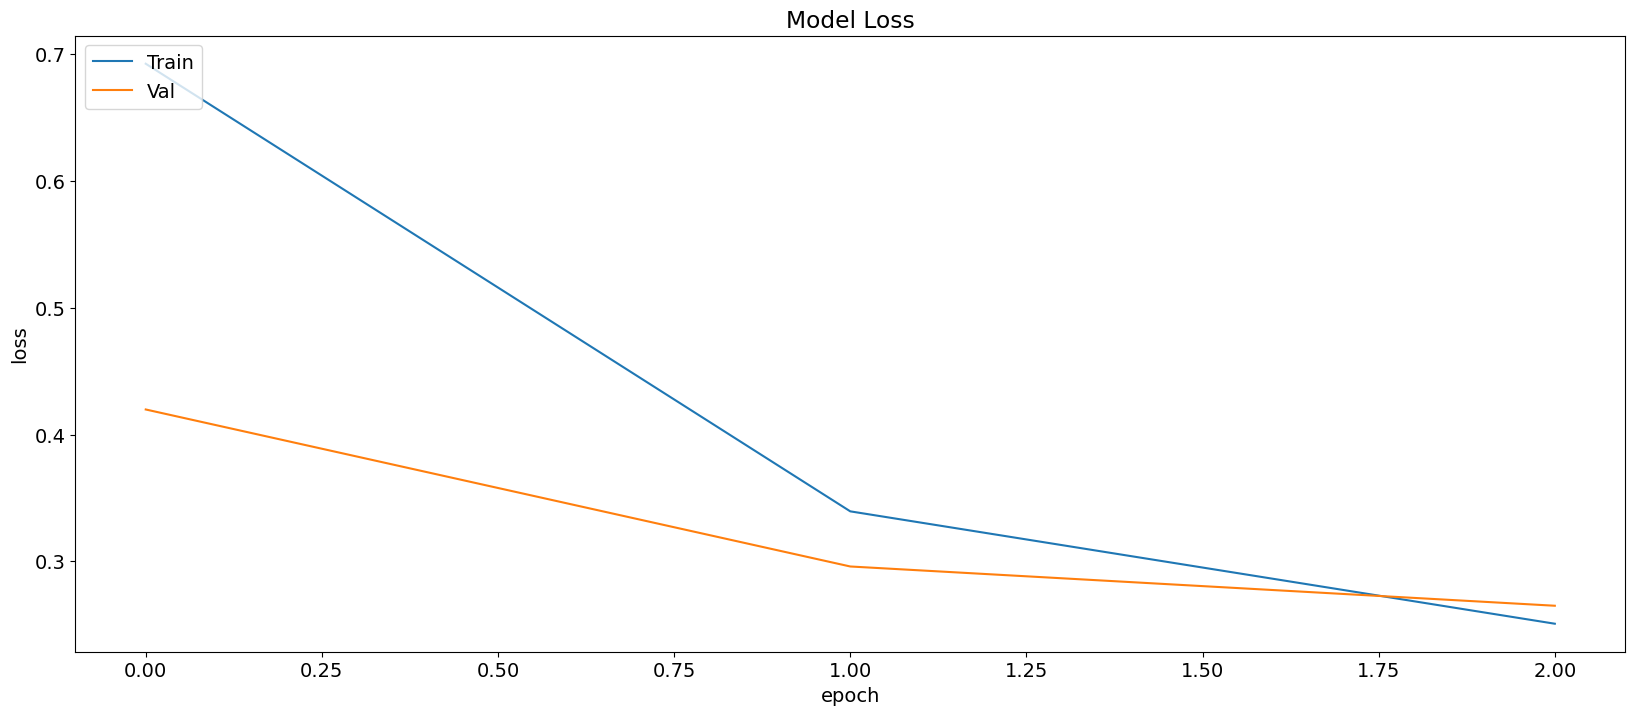

In [17]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

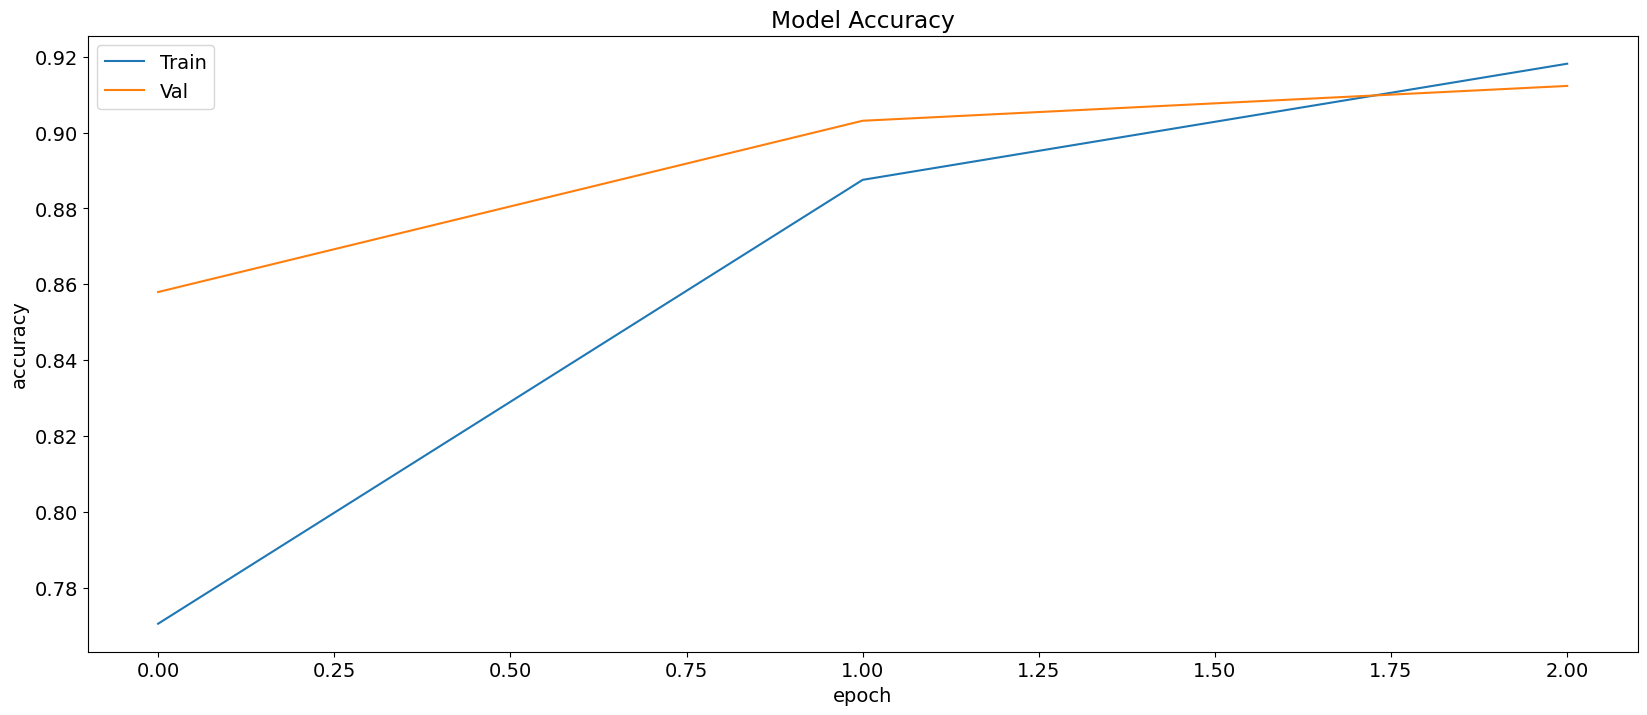

In [18]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [26]:
model = tf.keras.models.load_model('/kaggle/working/model.h5')

In [27]:
y_test = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_probs = y_pred.copy()

123/123 [==============================] - 49s 398ms/step


In [32]:
y_test

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [35]:
y_pred_int = np.argmax(y_pred_probs, axis=1)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
labels

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

In [39]:
print(classification_report(y_test,y_pred_int,target_names = labels))

              precision    recall  f1-score   support

        cane       0.91      0.90      0.91       729
     cavallo       0.88      0.92      0.90       393
    elefante       0.94      0.83      0.88       216
    farfalla       0.92      0.97      0.94       316
     gallina       0.94      0.96      0.95       464
       gatto       0.87      0.91      0.89       250
       mucca       0.89      0.85      0.87       279
      pecora       0.78      0.89      0.84       273
       ragno       0.96      0.98      0.97       723
  scoiattolo       1.00      0.75      0.85       279

    accuracy                           0.91      3922
   macro avg       0.91      0.90      0.90      3922
weighted avg       0.91      0.91      0.91      3922



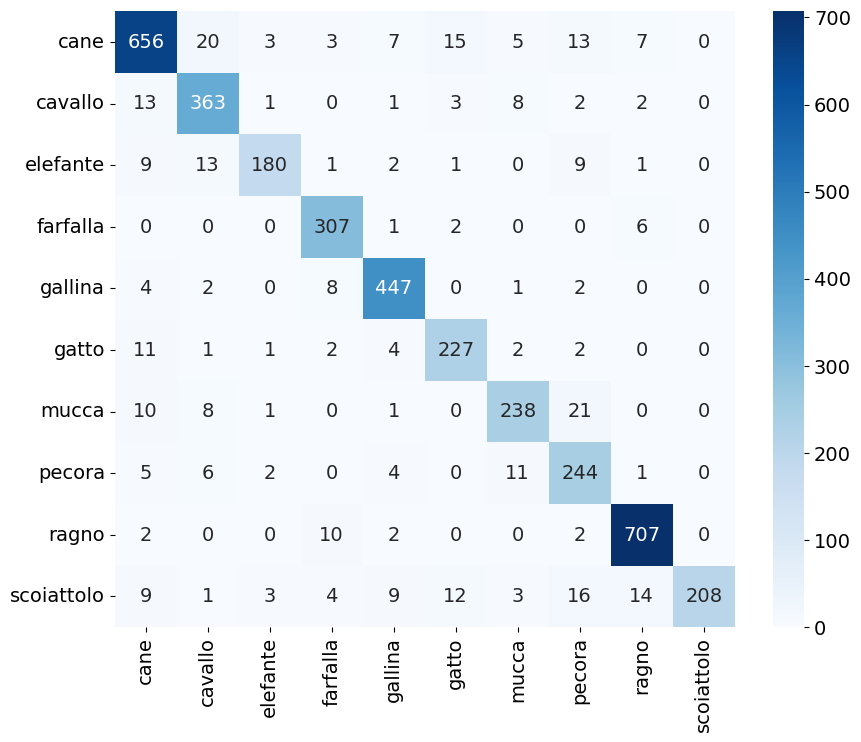

In [40]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred_int),annot=True,fmt='.3g',xticklabels=labels,
            yticklabels=labels,cmap='Blues')
plt.show()